# Composite Explainability

In [1]:
import numpy as np
import pandas as pd

seed = 0

df = pd.read_csv('selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

df.head()

,Flow rate_kurtosis,Zone3_Pressure_count_above_mean,Zone4_Pressure_count_above_mean,Zone5_Pressure_minimum,Zone6_Pressure_count_below_mean,Zone7_Pressure_minimum,Zone7_Pressure_count_below_mean,Zone7_Pressure_skewness,Zone9_Pressure_mean,Zone9_Pressure_kurtosis,...,Zone22_Pressure_count_below_mean,Zone23_Pressure_count_below_mean,Zone24_Pressure_kurtosis,Zone24_Pressure_count_below_mean,Zone24_Pressure_count_above_mean,Zone24_Pressure_skewness,Zone26_Pressure_count_above_mean,Zone29_Pressure_count_above_mean,Zone31_Pressure_count_below_mean,target
0,-0.568486,330,364,-2038.22,543,-1057.16,618,1.588478,7272.842730,5.311404,...,440,560,5.167330,708,149,2.473288,247,376,619,1
1,-0.507464,336,371,-2038.22,541,-1040.04,624,1.623811,7826.292369,5.748566,...,443,557,5.368426,717,144,2.516752,247,378,623,0
2,-0.766407,331,388,-1964.60,572,-1006.84,658,1.841518,7669.570471,7.946121,...,504,595,11.189778,749,143,3.445868,288,424,644,1
3,-0.712796,378,364,-2038.22,582,-1032.48,625,1.680860,9924.194251,2.121459,...,486,590,17.256859,721,182,3.720973,272,370,625,0
4,-0.504741,334,330,-1898.18,604,-1380.96,674,2.272728,3717.180958,9.245656,...,549,609,7.990006,722,217,2.840404,314,408,654,0


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, stratify=y)

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (6,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

##### RandomForestClassifier

In [4]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1562
           1       0.81      0.77      0.79      1743

    accuracy                           0.78      3305
   macro avg       0.78      0.78      0.78      3305
weighted avg       0.78      0.78      0.78      3305



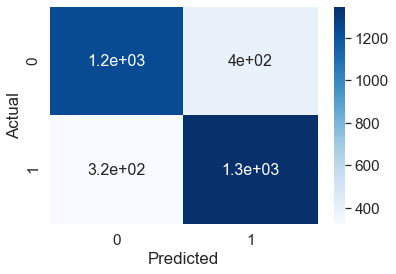

In [5]:
plot_confusion_matrix(y_pred, y_test)

##### XGBoostClassifier

In [6]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=10, n_estimators=100, random_state=seed)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
f1_score(y_pred, y_test)

0.7953823953823953

## SHAP

In [7]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

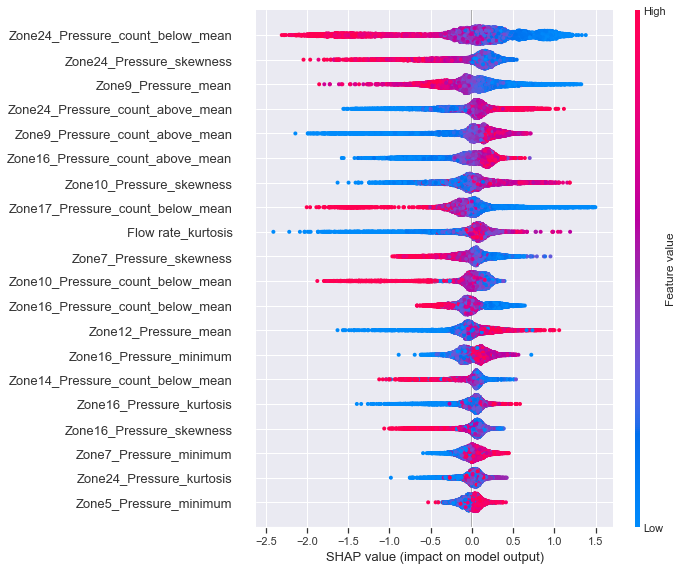

In [8]:
shap.summary_plot(shap_values, X)

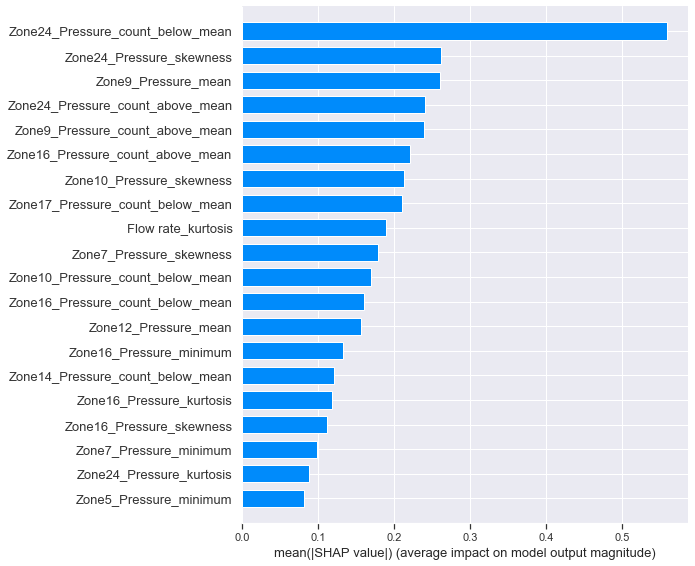

In [9]:
shap.summary_plot(shap_values, X, plot_type="bar")

## Interpret

In [10]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning_strategy='uniform', data_n_episodes=2000,
                              early_stopping_run_length=50,
                              early_stopping_tolerance=1e-05,
                              feature_names=['Flow rate_kurtosis',
                                             'Zone3_Pressure_count_above_mean',
                                             'Zone4_Pressure_count_above_mean',
                                             'Zone5_Pressure_minimum',
                                             'Zone6_Pressure_count_below_mean',
                                             'Zone7_Pressure_minimum',
                                             'Zone7_Pressure_count_bel...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous

In [11]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7729/2557480869640/ -->

In [12]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7729/2557531158408/ -->